# Extracting meteorological data for counties in USA - Precipitation data

## Setup

In [2]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import iris
import iris.plot as iplt
import iris.quickplot as qplt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import dask.dataframe as dd

import os
import sys
import glob

import shape_utils as shape

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Load Data

In [3]:
folders = glob.glob('/data/misc/covid-19/data_nc_daily/precip*')
filepaths = []
for folder in folders:
    filepaths.extend(glob.glob(os.path.join(folder, '*.nc')))
print(len(filepaths))

182


In [4]:
%%time
cubes = iris.load(filepaths)
    
print(cubes)

0: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 1920; longitude: 2560)
1: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 1920; longitude: 2560)
CPU times: user 12.2 s, sys: 636 ms, total: 12.8 s
Wall time: 1min 48s


In [5]:
us_latlon = ((18, 75), (-179, -65))
us_cubes = iris.cube.CubeList([cube.intersection(latitude=us_latlon[0], longitude=us_latlon[1]) for cube in cubes])
print(us_cubes)

0: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 608; longitude: 811)
1: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 608; longitude: 811)


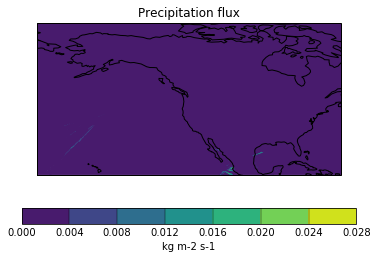

In [6]:
qplt.contourf(us_cubes[0][0])
plt.gca().coastlines()

In [7]:
CRS = us_cubes[0].coord_system()
CRS

GeogCS(6371229.0)

### Load shapefile

In [8]:
regions_shp = '/data/misc/covid-19/shapefiles/USA/US_COUNTY_POP.shx'
regions_reader = shpreader.Reader(regions_shp)

In [9]:
len([record for record in regions_reader.records()])

3142

In [10]:
next(regions_reader.records())

<Record: <shapely.geometry.multipolygon.MultiPolygon object at 0x7f33ae92e198>, {'OBJECTID': 1, 'NAME': 'Autauga', 'STATE_NAME': 'Alabama', 'STATE_FIPS': '01', 'CNTY_FIPS': '001', 'FIPS': '01001', 'POPULATION': 56903, 'POP_SQMI': 94.2, 'POP2010': 54571, 'POP10_SQMI': 90.3, 'WHITE': 42855, 'BLACK': 9643, 'AMERI_ES': 232, 'ASIAN': 474, 'HAWN_PI': 32, 'HISPANIC': 1310, 'OTHER': 466, 'MULT_RACE': 869, 'MALES': 26569, 'FEMALES': 28002, 'AGE_UNDER5': 3579, 'AGE_5_9': 3991, 'AGE_10_14': 4290, 'AGE_15_19': 4290, 'AGE_20_24': 3080, 'AGE_25_34': 6487, 'AGE_35_44': 8243, 'AGE_45_54': 8205, 'AGE_55_64': 5860, 'AGE_65_74': 4013, 'AGE_75_84': 1982, 'AGE_85_UP': 551, 'MED_AGE': 36.9, 'MED_AGE_M': 35.9, 'MED_AGE_F': 37.8, 'HOUSEHOLDS': 20221, 'AVE_HH_SZ': 2.68, 'HSEHLD_1_M': 2012, 'HSEHLD_1_F': 2429, 'MARHH_CHD': 5522, 'MARHH_NO_C': 5845, 'MHH_CHILD': 558, 'FHH_CHILD': 1821, 'FAMILIES': 15064, 'AVE_FAM_SZ': 3.13, 'HSE_UNITS': 22135, 'VACANT': 1914, 'OWNER_OCC': 15248, 'RENTER_OCC': 4973, 'NO_FARMS17':

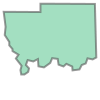

In [11]:
next(regions_reader.geometries())

In [12]:
# region_names = [record.attributes['NAME'] for record in regions_reader.records()]
# region_state = [record.attributes['STATE_NAME'] for record in regions_reader.records()]
# region_id = [record.attributes['OBJECTID'] for record in regions_reader.records()]
# region_fips = [record.attributes['FIPS'] for record in reguins_reader.records()]
# county_fips = [record.attributes['CNTY_FIPS'] for record in regions_reader.records()]
# state_fips = [record.attributes['STATE_FIPS'] for record in regions_reader.records()]

In [13]:
region_ids = [record.attributes['OBJECTID'] for record in regions_reader.records()]

In [14]:
print(region_ids[0], region_ids[-1])

1 3142


In [15]:
def get_region_record(target, shapefile=regions_reader, attribute='OBJECTID'):
    '''
    Get the geometries for the specified location.
    
    '''
    result = None
    for record in shapefile.records():
        location = record.attributes[attribute]
        if location == target:
            result = record
            break
    if result is None:
        emsg = 'Could not find region with name "{}".'
        raise ValueError(emsg.format(target))
    return result

In [16]:
from random import randint
def rand_id(ids=region_ids): 
    return randint(ids[0], ids[-1])

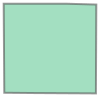

In [17]:
get_region_record(rand_id()).geometry

## Work out which files have been written, and which still have to be

In [29]:
csvs = glob.glob('/data/misc/covid-19/us_data_precip/*.csv')
len(csvs)

3134

In [ ]:
df = pd.concat([pd.read_csv(csv) for csv in csvs], ignore_index=True)
df

In [ ]:
written = list(df['region'].unique().compute())
written

In [ ]:
len(written)

In [ ]:
unwritten = list(set(region_names).difference(set(written)))
len(unwritten)

In [ ]:
unwritten

In [ ]:
len(unwritten)+len(written)

## Create a pipeline

In [19]:
def parse_data_name(cube):
    name = cube.name()
    method = cube.cell_methods[1].method.replace('imum', '')
    units = cube.units
    
    if name == 'm01s01i202':
        name = 'short_wave_radiation'
        units = 'W/m2'
    
    return f'{name}_{method} ({units})'

In [20]:
col0 = ['objectid', 'fips', 'county_name', 'state_name', 'date']
col1 = [parse_data_name(cube) for cube in us_cubes]

In [21]:
COL_ORDER = tuple(col0 + sorted([c for c in col1 if c not in col0]))
COL_ORDER

('objectid',
 'fips',
 'county_name',
 'state_name',
 'date',
 'precipitation_flux_max (kg m-2 s-1)',
 'precipitation_flux_mean (kg m-2 s-1)')

In [22]:
def extract(location, cubes=us_cubes, **kwargs):
    region = get_region_record(location, **kwargs)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(cubes)
#     cubes_col = [cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes]
    return cut_cubes

In [23]:
def extract_collapse_df(location, cubes=us_cubes, **kwargs):
    region = get_region_record(location, **kwargs)
    cutter = shape.Shape(region.geometry, region.attributes, coord_system=CRS)
    cut_cubes = cutter.extract_subcubes(cubes)
    cubes_col = [cube.collapsed(['latitude','longitude'], iris.analysis.MEAN) for cube in cut_cubes]
    time = cubes_col[0].coord('time')
    length = len(time.points)
    data = {'objectid': [location]*length,
            'fips': [region.attributes['FIPS']]*length,
            'county_name': [region.attributes['NAME']]*length,
            'state_name': [region.attributes['STATE_NAME']]*length,
            'date': [cell.point.date() for cell in time.cells()]}
    data.update({parse_data_name(cube): cube.data for cube in cubes_col})
    
    df = pd.DataFrame(data, columns=COL_ORDER)

    return df

899
0: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 5; longitude: 5)
1: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 5; longitude: 5)


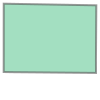

In [24]:
id_ = rand_id()
print(id_)
print(extract(id_, us_cubes, attribute='OBJECTID'))
display(get_region_record(id_, attribute='OBJECTID').geometry)

In [25]:
%%time
df_ex = extract_collapse_df(id_)
df_ex

CPU times: user 3.18 s, sys: 2.89 s, total: 6.08 s
Wall time: 4.13 s


,objectid,fips,county_name,state_name,date,precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,899,20021,Cherokee,Kansas,2020-01-01,0.000000,0.000000e+00
1,899,20021,Cherokee,Kansas,2020-01-02,0.000000,0.000000e+00
2,899,20021,Cherokee,Kansas,2020-01-03,0.000002,7.629394e-08
3,899,20021,Cherokee,Kansas,2020-01-04,0.000000,0.000000e+00
4,899,20021,Cherokee,Kansas,2020-01-05,0.000000,0.000000e+00
...,...,...,...,...,...,...,...
86,899,20021,Cherokee,Kansas,2020-03-27,0.000033,1.977285e-06
87,899,20021,Cherokee,Kansas,2020-03-28,0.001091,7.574081e-05
88,899,20021,Cherokee,Kansas,2020-03-29,0.000000,0.000000e+00
89,899,20021,Cherokee,Kansas,2020-03-30,0.000133,6.167094e-06


## Save dataframe to csv for each location

In [89]:
print(us_cubes)

0: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 608; longitude: 811)
1: precipitation_flux / (kg m-2 s-1)   (time: 91; latitude: 608; longitude: 811)


In [26]:
unwritten = region_ids
len(csvs)

3

In [27]:
%%time
dfs = []
start = len(csvs)
stop = len(region_ids)
for location in unwritten[start:]:
    try:
        df = extract_collapse_df(location)
#         dfs.append(df)
        fname = df['fips'][0]
        county = df['county_name'][0]
        state = df['state_name'][0]
        df.to_csv(f'/data/misc/covid-19/us_data_precip/us_{fname}_daily_precipdata_2020jan-mar.csv', index=False)
        print(f'  [{location}] {fname}, {county}, {state}: Success')
#         display(df.iloc[[0]])
    except Exception as e:
        print(f'x [{location}] {fname}, {county}, {state}: Error \n  x  {e}')

  [4] 01007, Bibb, Alabama: Success
  [5] 01009, Blount, Alabama: Success
  [6] 01011, Bullock, Alabama: Success
  [7] 01013, Butler, Alabama: Success
  [8] 01015, Calhoun, Alabama: Success
  [9] 01017, Chambers, Alabama: Success
  [10] 01019, Cherokee, Alabama: Success
  [11] 01021, Chilton, Alabama: Success
  [12] 01023, Choctaw, Alabama: Success
  [13] 01025, Clarke, Alabama: Success
  [14] 01027, Clay, Alabama: Success
  [15] 01029, Cleburne, Alabama: Success
  [16] 01031, Coffee, Alabama: Success
  [17] 01033, Colbert, Alabama: Success
  [18] 01035, Conecuh, Alabama: Success
  [19] 01037, Coosa, Alabama: Success
  [20] 01039, Covington, Alabama: Success
  [21] 01041, Crenshaw, Alabama: Success
  [22] 01043, Cullman, Alabama: Success
  [23] 01045, Dale, Alabama: Success
  [24] 01047, Dallas, Alabama: Success
  [25] 01049, DeKalb, Alabama: Success
  [26] 01051, Elmore, Alabama: Success
  [27] 01053, Escambia, Alabama: Success
  [28] 01055, Etowah, Alabama: Success
  [29] 01057, Faye

**NB: 7 counties returned errors when being written (6 in Virginia, 1 in Masachusettes), but every one seemed to be a duplicate so all counties have been written**

## Open all the written CSVs and concatenate them into a mega DataFrame

In [29]:
csvs = glob.glob('/data/misc/covid-19/us_data_precip/*.csv')
len(csvs)

3134

In [30]:
%%time
Mdf = pd.concat([pd.read_csv(csv) for csv in csvs], ignore_index=True)
Mdf

CPU times: user 10.9 s, sys: 104 ms, total: 11 s
Wall time: 1min 8s


,objectid,fips,county_name,state_name,date,precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,2,1003,Baldwin,Alabama,2020-01-01,5.868765e-07,2.934382e-08
1,2,1003,Baldwin,Alabama,2020-01-02,8.980384e-04,1.482157e-04
2,2,1003,Baldwin,Alabama,2020-01-03,3.354762e-03,4.018906e-04
3,2,1003,Baldwin,Alabama,2020-01-04,3.474896e-04,3.155439e-05
4,2,1003,Baldwin,Alabama,2020-01-05,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...
285189,3142,56045,Weston,Wyoming,2020-03-27,2.282460e-04,3.296358e-05
285190,3142,56045,Weston,Wyoming,2020-03-28,1.884037e-04,1.149707e-05
285191,3142,56045,Weston,Wyoming,2020-03-29,5.298191e-08,2.207580e-09
285192,3142,56045,Weston,Wyoming,2020-03-30,1.064936e-05,8.278423e-07


In [31]:
def df_hists(df):
    for col in df:
        plt.hist(df[col])
        plt.title(f'{col}')
        plt.show()

In [36]:
Mdf[Mdf.columns[5:]]

,precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,5.868765e-07,2.934382e-08
1,8.980384e-04,1.482157e-04
2,3.354762e-03,4.018906e-04
3,3.474896e-04,3.155439e-05
4,0.000000e+00,0.000000e+00
...,...,...
285189,2.282460e-04,3.296358e-05
285190,1.884037e-04,1.149707e-05
285191,5.298191e-08,2.207580e-09
285192,1.064936e-05,8.278423e-07


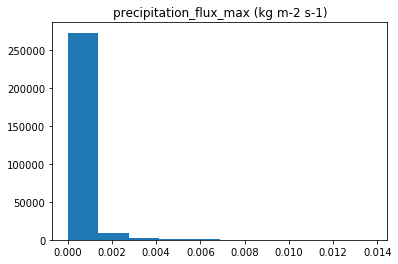

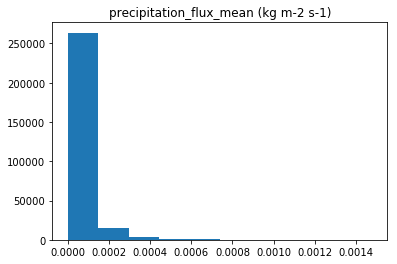

CPU times: user 4.25 s, sys: 0 ns, total: 4.25 s
Wall time: 332 ms


In [37]:
%%time
df_hists(Mdf[Mdf.columns[5:]])

**Data looks sensible, I think we have successfully made a mega dataframe!**

## Let's now write that out to a file

In [87]:
%%time
Mdf.to_csv(f'/data/misc/covid-19/us_data_precip/us_daily_precipdata_2020jan-mar_v01.csv', index=False)

CPU times: user 1.52 s, sys: 0 ns, total: 1.52 s
Wall time: 2.21 s


## Now we need to load the other mega dataframe and merge it with the precip dataframe we just made

In [52]:
fulldf = pd.read_csv('/data/misc/covid-19/us_data/us_daily_meteodata_2020jan-mar_v01.csv')
fulldf

,objectid,fips,county_name,state_name,date,air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1)
0,1,1001,Autauga,Alabama,2020-01-01,285.33438,279.35843,274.33188,473.59810,116.839890,0.005674,0.004174,0.003506
1,1,1001,Autauga,Alabama,2020-01-02,291.24940,283.89390,281.15440,105.63250,15.552084,0.012490,0.007238,0.004883
2,1,1001,Autauga,Alabama,2020-01-03,293.15936,291.26650,289.47060,256.00500,40.375362,0.014072,0.012423,0.010752
3,1,1001,Autauga,Alabama,2020-01-04,289.10126,286.74954,282.57126,510.31560,104.776360,0.011064,0.008149,0.003564
4,1,1001,Autauga,Alabama,2020-01-05,285.04187,278.90695,273.65686,537.78186,136.104390,0.005654,0.003919,0.003408
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285189,3142,56045,Weston,Wyoming,2020-03-27,278.69120,275.13052,272.13434,442.58768,98.734856,0.004842,0.004249,0.003493
285190,3142,56045,Weston,Wyoming,2020-03-28,280.27386,275.38205,271.37305,618.07837,159.618230,0.004462,0.003483,0.002580
285191,3142,56045,Weston,Wyoming,2020-03-29,283.36438,276.39145,270.92166,647.37585,176.251600,0.003747,0.003050,0.002543
285192,3142,56045,Weston,Wyoming,2020-03-30,286.19727,278.87650,272.24066,673.12240,190.814130,0.004055,0.003298,0.002601


### How do I add the two dataframes together such that their rows line up?

In [46]:
df1 = pd.DataFrame({'name': ['a','b','c'], 'a': [1,2,3], 'b':[1,2,3]})
df2 = pd.DataFrame({'name': ['a','c'], 'a': [1,3], 'c':[1,3]})

In [47]:
pd.concat([df1, df2['c']], ignore_index=True)

,0,a,b,name
0,NaN,1.0,1.0,a
1,NaN,2.0,2.0,b
2,NaN,3.0,3.0,c
3,1.0,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN


In [48]:
df1.merge(df2, how='inner')

,name,a,b,c
0,a,1,1,1
1,c,3,3,3


In [60]:
df1.merge(df2, how='outer', on=['name', 'a'])

,name,a,b,c
0,a,1,1,1.0
1,b,2,2,NaN
2,c,3,3,3.0


In [50]:
df1.merge(df2, how='right')

,name,a,b,c
0,a,1,1,1
1,c,3,3,3


In [51]:
df1.merge(df2, how='left')

,name,a,b,c
0,a,1,1,1.0
1,b,2,2,NaN
2,c,3,3,3.0


**So we will need to use `merge` with either `outer` or `left`. Let's go with `left`, since it preserves the rows of the larger dataframe**

### To ensure the dataframes merge exactly on their common rows, let's pass all their common columns to `merge()`, which we defined in `col0` earlier

In [54]:
col0

['objectid', 'fips', 'county_name', 'state_name', 'date']

In [72]:
mergedf = fulldf.merge(Mdf, how='left', on=col0)
mergedf

,objectid,fips,county_name,state_name,date,air_temperature_max (K),air_temperature_mean (K),air_temperature_min (K),short_wave_radiation_max (W/m2),short_wave_radiation_mean (W/m2),specific_humidity_max (1),specific_humidity_mean (1),specific_humidity_min (1),precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,1,1001,Autauga,Alabama,2020-01-01,285.33438,279.35843,274.33188,473.59810,116.839890,0.005674,0.004174,0.003506,0.000000e+00,0.000000e+00
1,1,1001,Autauga,Alabama,2020-01-02,291.24940,283.89390,281.15440,105.63250,15.552084,0.012490,0.007238,0.004883,1.833191e-03,3.875414e-04
2,1,1001,Autauga,Alabama,2020-01-03,293.15936,291.26650,289.47060,256.00500,40.375362,0.014072,0.012423,0.010752,3.753662e-04,6.991068e-05
3,1,1001,Autauga,Alabama,2020-01-04,289.10126,286.74954,282.57126,510.31560,104.776360,0.011064,0.008149,0.003564,6.988525e-04,7.470448e-05
4,1,1001,Autauga,Alabama,2020-01-05,285.04187,278.90695,273.65686,537.78186,136.104390,0.005654,0.003919,0.003408,1.525879e-07,6.357829e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
285189,3142,56045,Weston,Wyoming,2020-03-27,278.69120,275.13052,272.13434,442.58768,98.734856,0.004842,0.004249,0.003493,2.282460e-04,3.296358e-05
285190,3142,56045,Weston,Wyoming,2020-03-28,280.27386,275.38205,271.37305,618.07837,159.618230,0.004462,0.003483,0.002580,1.884037e-04,1.149707e-05
285191,3142,56045,Weston,Wyoming,2020-03-29,283.36438,276.39145,270.92166,647.37585,176.251600,0.003747,0.003050,0.002543,5.298191e-08,2.207580e-09
285192,3142,56045,Weston,Wyoming,2020-03-30,286.19727,278.87650,272.24066,673.12240,190.814130,0.004055,0.003298,0.002601,1.064936e-05,8.278423e-07


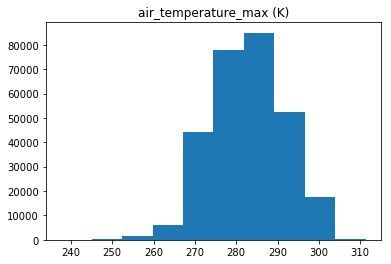

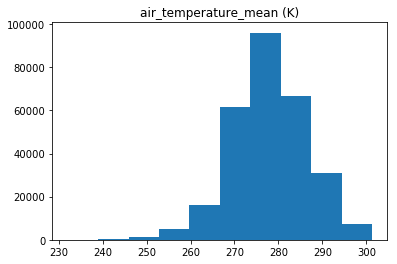

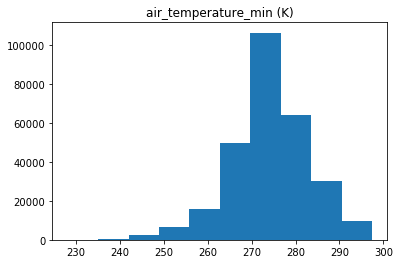

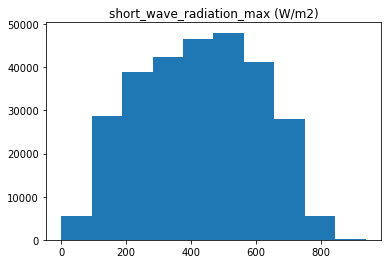

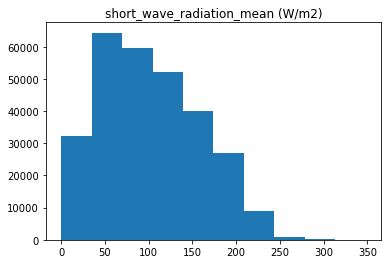

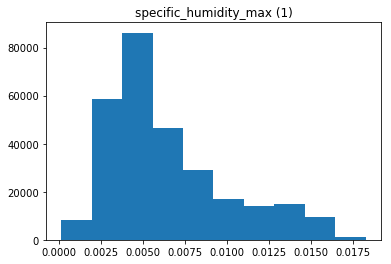

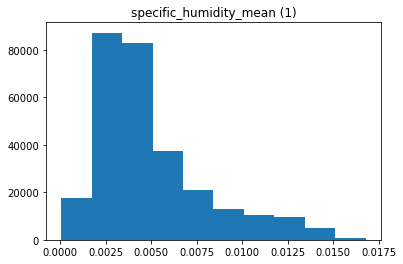

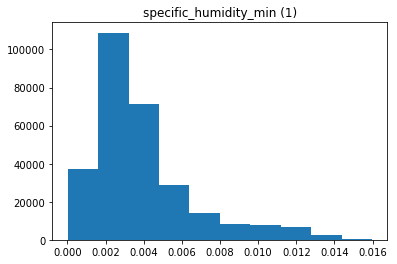

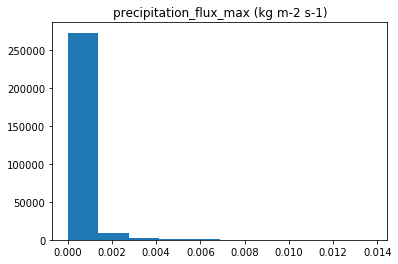

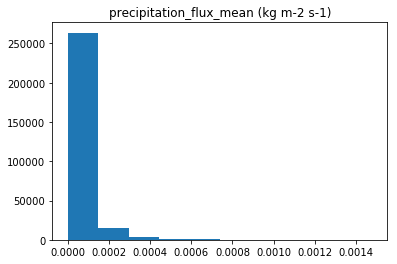

CPU times: user 18.9 s, sys: 0 ns, total: 18.9 s
Wall time: 1.44 s


In [56]:
%%time
df_hists(mergedf[mergedf.columns[5:]])

**Success! The data looks good**

### Now let's check that all the values in `Mdf` and `mergedf` are the same for the columns we added

First we need to get `Mdf` on the same indices as `mergdf`

In [88]:
mdfsort = Mdf.sort_values(by=['objectid', 'date']).reset_index(drop=True)
mdfsort

,objectid,fips,county_name,state_name,date,precipitation_flux_max (kg m-2 s-1),precipitation_flux_mean (kg m-2 s-1)
0,1,1001,Autauga,Alabama,2020-01-01,0.000000e+00,0.000000e+00
1,1,1001,Autauga,Alabama,2020-01-02,1.833191e-03,3.875414e-04
2,1,1001,Autauga,Alabama,2020-01-03,3.753662e-04,6.991068e-05
3,1,1001,Autauga,Alabama,2020-01-04,6.988525e-04,7.470448e-05
4,1,1001,Autauga,Alabama,2020-01-05,1.525879e-07,6.357829e-09
...,...,...,...,...,...,...,...
285189,3142,56045,Weston,Wyoming,2020-03-27,2.282460e-04,3.296358e-05
285190,3142,56045,Weston,Wyoming,2020-03-28,1.884037e-04,1.149707e-05
285191,3142,56045,Weston,Wyoming,2020-03-29,5.298191e-08,2.207580e-09
285192,3142,56045,Weston,Wyoming,2020-03-30,1.064936e-05,8.278423e-07


In [92]:
for col in mdfsort:
    print(mergedf[col].all() == mdfsort[col].all())

True
True
True
True
True
True
True


#### And for good measure let's check it with `fulldf`

In [91]:
for col in fulldf:
    print(mergedf[col].all() == fulldf[col].all())

True
True
True
True
True
True
True
True
True
True
True
True
True


In [93]:
%%time
mergedf.to_csv(f'/data/misc/covid-19/us_daily_meteodata_2020jan-mar_v02.csv', index=False)

CPU times: user 4.62 s, sys: 0 ns, total: 4.62 s
Wall time: 6.16 s


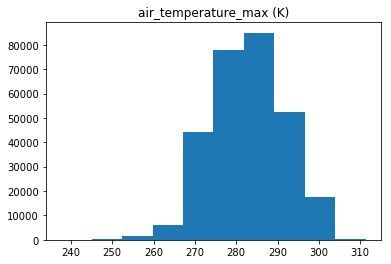

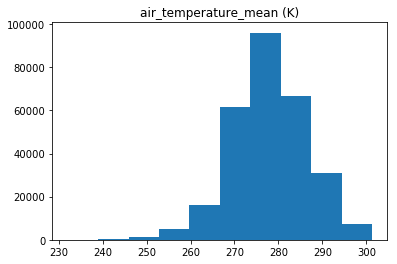

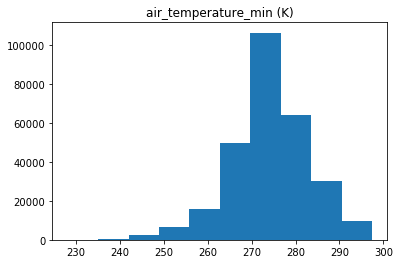

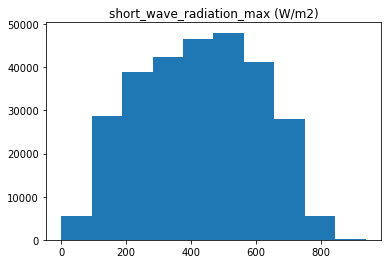

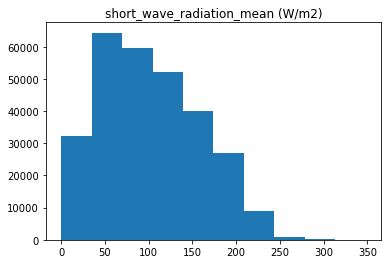

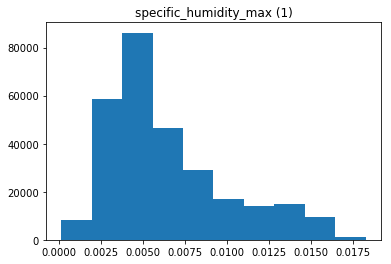

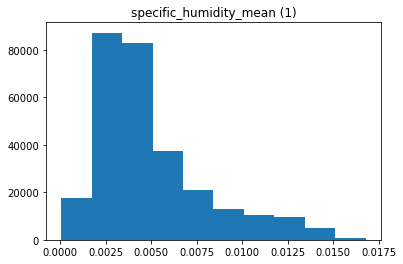

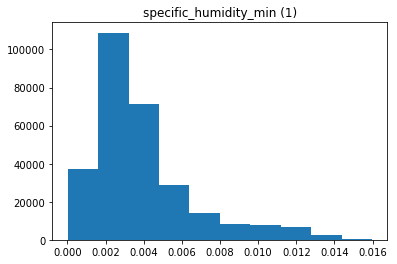

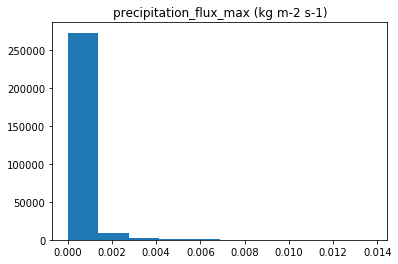

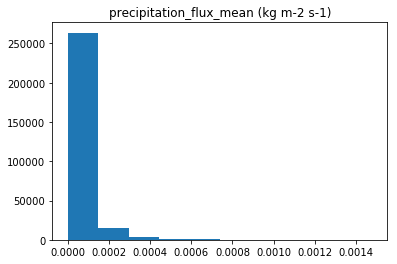

CPU times: user 18.8 s, sys: 0 ns, total: 18.8 s
Wall time: 2.09 s


In [94]:
%%time
mdf = pd.read_csv('/data/misc/covid-19/us_daily_meteodata_2020jan-mar_v02.csv')
df_hists(mdf[mdf.columns[5:]])